In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange

olefile module not found


In [2]:
# need to change
ipts="29313"

In [3]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
os.listdir(ct_loc)

['2022_10_14_high_res_0_180',
 '2022_10_14_high_res',
 '2022_10_13_set2',
 '2022_10_13_set1',
 '2022_10_12_set1']

In [4]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2022_10_14_high_res', '2022_10_13_set2', '2022_10_12']

In [5]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
os.listdir(dc_loc)

['2022_10_14_high_res', '2022_10_13_set2', '2022_10_10']

In [6]:
###################### need to change start
sample_name = "2022_10_14_high_res"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_10_14_high_res")
dc_dir = os.path.join(dc_loc, "2022_10_14_high_res")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon/" + sample_name
ob_name = save_to + "/" + 'ob_0000'
dc_name = save_to + "/" + 'dc_0000'
###################### need to change end

# Find ROI and crop

In [7]:
ct_file_list = os.listdir(ct_dir)

In [8]:
# ct_file_list.remove('20221108_dummy_0005_000_000_0044.tiff')

In [9]:
fname_df = rocku.get_fname_df(ct_file_list, golden_ratio=False)
fname_df.sort_values('ang_deg', inplace=True)

In [10]:
ang_list = fname_df['ang_deg'].to_list()
ordered_list = fname_df['fname'].to_list()

In [11]:
fname_df

,fname,ang_deg,ang_rad,idx
3651,20221014_H1_H2_moved_0030_000_350_0047.tiff,0.35,0.006109,47
6005,20221014_H1_H2_moved_0030_000_350_0051.tiff,0.35,0.006109,51
3037,20221014_H1_H2_moved_0030_000_350_0045.tiff,0.35,0.006109,45
5855,20221014_H1_H2_moved_0030_000_350_0048.tiff,0.35,0.006109,48
2663,20221014_H1_H2_moved_0030_000_350_0046.tiff,0.35,0.006109,46
...,...,...,...,...
6070,20221014_H1_H2_moved_0030_359_910_0041.tiff,359.91,6.281615,41
8462,20221014_H1_H2_moved_0030_359_910_0037.tiff,359.91,6.281615,37
115,20221014_H1_H2_moved_0030_359_910_0039.tiff,359.91,6.281615,39
8074,20221014_H1_H2_moved_0030_359_910_0035.tiff,359.91,6.281615,35


2it [00:00,  5.85it/s]


Projection at 0 degree:


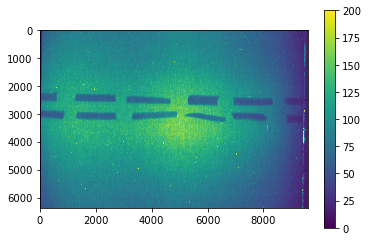

Projection at 180 degree:


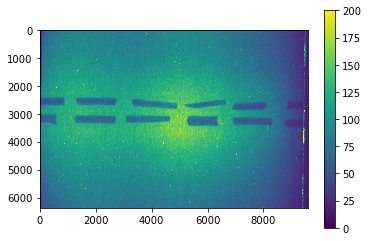

In [12]:
proj180_idx, proj180_ang = rocku.find_idx_by_ang(ang_list, 180)
proj000_idx, proj000_ang = rocku.find_idx_by_ang(ang_list, 0)
preview_image_stack = rocku.read_tiff_stack(ct_dir, [ordered_list[proj000_idx], ordered_list[proj180_idx]])
print("Projection at 0 degree:")
plt.imshow(preview_image_stack[0], vmin=0, vmax=200)
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(preview_image_stack[1], vmin=0, vmax=200)
plt.colorbar()
plt.show()

In [16]:
preview_image_stack.shape

(2, 6388, 9576)

Projection at 0 degree:


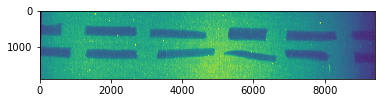

Projection at 180 degree:


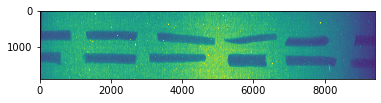

In [17]:
###################### need to change start
crop = True
crop_left = 0
crop_right = 9400
crop_top = 1900
crop_bottom = 3800
###################### need to change end
preview_image_stack_crop = rocku.crop(preview_image_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Projection at 0 degree:")
plt.imshow(preview_image_stack_crop[0], vmin=0, vmax=200)
plt.show()
print("Projection at 180 degree:")
plt.imshow(preview_image_stack_crop[1], vmin=0, vmax=200)
plt.show()

# Preprocess OB

Loading OB ...


27it [00:06,  3.98it/s]


(27, 6388, 9576)
Cropping ...
Removing outliers ...
Combining with median ...
(1900, 9400)
Rotating by 90 deg ...
(9400, 1900)


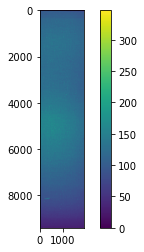

In [18]:
print('Loading OB ...')
ob_stack = rocku.read_tiff_stack(ob_dir, os.listdir(ob_dir))
print(ob_stack.shape)
print('Cropping ...')
ob_stack_crop = rocku.crop(ob_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
print('Removing outliers ...')
ob_stack_cleaned = tomopy.remove_outlier(ob_stack_crop, gamma_diff)
print('Combining with median ...')
if ob_stack_cleaned.shape[0] == 1:
    ob_med = ob_stack_cleaned[:]
else:
    ob_med = np.median(ob_stack_cleaned, axis=0).astype(np.ushort)
print(ob_med.shape)
print('Rotating by 90 deg ...')
ob_rot = np.rot90(ob_med, k=-1)
print(ob_rot.shape)
plt.imshow(ob_rot)
plt.colorbar()
plt.show()
print('Saving {} ...'.format(ob_name))
dxchange.write_tiff(ob_rot, fname=ob_name, overwrite=True)

# Preprocess DC

Loading DC ...


27it [00:07,  3.76it/s]


(27, 6388, 9576)
Cropping ...
Removing outliers ...
Combining with median ...
(1900, 9400)
Rotating by 90 deg ...
(9400, 1900)


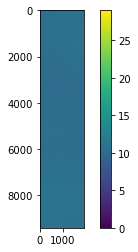

In [19]:
print('Loading DC ...')
dc_stack = rocku.read_tiff_stack(dc_dir, os.listdir(dc_dir))
print(dc_stack.shape)
print('Cropping ...')
dc_stack_crop = rocku.crop(dc_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
print('Removing outliers ...')
dc_stack_cleaned = tomopy.remove_outlier(dc_stack_crop, gamma_diff)
print('Combining with median ...')
if dc_stack_cleaned.shape[0] == 1:
    dc_med = dc_stack_cleaned[:]
else:
    dc_med = np.median(dc_stack_cleaned, axis=0).astype(np.ushort)
print(dc_med.shape)
print('Rotating by 90 deg ...')
dc_rot = np.rot90(dc_med, k=-1)
print(dc_rot.shape)
plt.imshow(dc_rot)
plt.colorbar()
plt.show()
# print('Saving {} ...'.format(dc_name))
# dxchange.write_tiff(dc_rot, fname=dc_name, overwrite=True)

# Preprocess CT scan files

In [20]:
ang_deg_list = sorted(list(set(fname_df['ang_deg'])))
group_size = ang_list.count(ang_list[0]) # get the group size automatically
grouped_list = ordered_list[::group_size]
grouped_dict = {}
for i, e_ang in enumerate(ang_deg_list):
    _fname_list = list(fname_df[fname_df['ang_deg'] == e_ang]['fname'])
    grouped_dict[grouped_list[i]] = _fname_list
pprint.pprint(grouped_dict)

{'20221014_H1_H2_moved_0030_000_350_0047.tiff': ['20221014_H1_H2_moved_0030_000_350_0047.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0051.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0045.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0048.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0046.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0043.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0050.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0049.tiff',
                                                 '20221014_H1_H2_moved_0030_000_350_0044.tiff'],
 '20221014_H1_H2_moved_0030_000_700_0053.tiff': ['20221014_H1_H2_moved_0030_000_700_0053.tiff',
                                       

 '20221015_H1_H2_moved_0030_061_600_1625.tiff': ['20221015_H1_H2_moved_0030_061_600_1625.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1624.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1621.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1623.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1619.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1622.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1620.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1626.tiff',
                                                 '20221015_H1_H2_moved_0030_061_600_1618.tiff'],
 '20221015_H1_H2_moved_0030_061_950_1627.tiff': ['20221015_H1_H2_moved_0030_061_950_1627.tiff',
                                       

                                                 '20221015_H1_H2_moved_0030_122_500_3189.tiff',
                                                 '20221015_H1_H2_moved_0030_122_500_3185.tiff',
                                                 '20221015_H1_H2_moved_0030_122_500_3187.tiff',
                                                 '20221015_H1_H2_moved_0030_122_500_3190.tiff'],
 '20221015_H1_H2_moved_0030_122_850_3197.tiff': ['20221015_H1_H2_moved_0030_122_850_3197.tiff',
                                                 '20221015_H1_H2_moved_0030_122_850_3198.tiff',
                                                 '20221015_H1_H2_moved_0030_122_850_3194.tiff',
                                                 '20221015_H1_H2_moved_0030_122_850_3196.tiff',
                                                 '20221015_H1_H2_moved_0030_122_850_3199.tiff',
                                                 '20221015_H1_H2_moved_0030_122_850_3195.tiff',
                                       

                                                 '20221016_H1_H2_moved_0030_177_800_4614.tiff',
                                                 '20221016_H1_H2_moved_0030_177_800_4611.tiff',
                                                 '20221016_H1_H2_moved_0030_177_800_4607.tiff',
                                                 '20221016_H1_H2_moved_0030_177_800_4610.tiff',
                                                 '20221016_H1_H2_moved_0030_177_800_4606.tiff'],
 '20221016_H1_H2_moved_0030_178_150_4621.tiff': ['20221016_H1_H2_moved_0030_178_150_4621.tiff',
                                                 '20221016_H1_H2_moved_0030_178_150_4619.tiff',
                                                 '20221016_H1_H2_moved_0030_178_150_4616.tiff',
                                                 '20221016_H1_H2_moved_0030_178_150_4623.tiff',
                                                 '20221016_H1_H2_moved_0030_178_150_4617.tiff',
                                       

                                                 '20221017_H1_H2_moved_0030_248_150_6419.tiff',
                                                 '20221017_H1_H2_moved_0030_248_150_6423.tiff',
                                                 '20221017_H1_H2_moved_0030_248_150_6418.tiff',
                                                 '20221017_H1_H2_moved_0030_248_150_6422.tiff'],
 '20221017_H1_H2_moved_0030_248_500_6429.tiff': ['20221017_H1_H2_moved_0030_248_500_6429.tiff',
                                                 '20221017_H1_H2_moved_0030_248_500_6425.tiff',
                                                 '20221017_H1_H2_moved_0030_248_500_6424.tiff',
                                                 '20221017_H1_H2_moved_0030_248_500_6427.tiff',
                                                 '20221017_H1_H2_moved_0030_248_500_6430.tiff',
                                                 '20221017_H1_H2_moved_0030_248_500_6432.tiff',
                                       

 '20221017_H1_H2_moved_0030_310_450_8020.tiff': ['20221017_H1_H2_moved_0030_310_450_8020.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8017.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8024.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8019.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8025.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8021.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8018.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8022.tiff',
                                                 '20221017_H1_H2_moved_0030_310_450_8023.tiff'],
 '20221017_H1_H2_moved_0030_310_800_8027.tiff': ['20221017_H1_H2_moved_0030_310_800_8027.tiff',
                                       

In [21]:
for each in grouped_dict.keys():
    deg_key = rocku.get_deg(each)
    for e_item in grouped_dict[each]:
        if rocku.get_deg(e_item) != deg_key:
            print(each)
        else:
            print('Pass')

Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass


Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass


Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass


Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass


Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass


In [23]:
# for e_group in ['20221001_battery_0030_000_000_2824.tiff']:
for e_group in grouped_dict.keys():
    _fname_list = grouped_dict[e_group]
    print('Processing group start with {} ...'.format(e_group))
    print('Loading ...')
    _image_stack = rocku.read_tiff_stack(ct_dir, _fname_list)
    print('Cropping ...')
    _image_stack_crop = rocku.crop(_image_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
    print('Removing outliers ...')
    _image_stack_cleaned = tomopy.remove_outlier(_image_stack_crop, gamma_diff)
    print('Combining with median ...')
    _image_med = np.median(_image_stack_cleaned, axis=0).astype(np.ushort)
    print('Rotating by 90 deg ...')
    _image_rot = np.rot90(_image_med, k=-1)
    fname = save_to + "/" + e_group
    print('Saving {} ...'.format(fname))
    dxchange.write_tiff(_image_rot, fname=fname, overwrite=True)

Processing group start with 20221018_H1_H2_moved_0030_000_000_9295.tiff ...
Loading ...
Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/raw_to_recon/2022_10_14_high_res_0_180/20221018_H1_H2_moved_0030_000_000_9295.tiff ...
Processing group start with 20221018_H1_H2_moved_0030_180_000_9304.tiff ...
Loading ...
Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Saving /HFIR/CG1D/IPTS-29313/shared/autoreduce/raw_to_recon/2022_10_14_high_res_0_180/20221018_H1_H2_moved_0030_180_000_9304.tiff ...
